# Fit bmimpf6 data

EoS: PR

Parameter T dependence: Linear in [bmimpf6,R32] direction

N (total fitting parameters): 3

## Import Functions

In [1]:
import idaes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import sys
sys.path.append('../../')

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.opt import TerminationCondition, SolverStatus

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

# parmest (binary_param2)
from bip_fitting_functions import linear

import scipy.stats as stats

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

## Load Data

In [2]:
data_full = pd.read_csv('r32_bmimpf6_full.csv')
# data_subset = pd.read_csv('r32_emimtf2n_subset.csv')

## Load Configuration + Check DOF

In [3]:
from hfc32_bmimpf6_PR import configuration 

In [4]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

The initial DOF is 7


## Fit Parameters

In [6]:
parameters, obj_value, a = linear(data_full, configuration, 'R32', 'bmimpf6', "x_R32", "x_bmimpf6", 
    init_temp =  283.1, init_press =   399300 , init_x_c1 =    0.448, init_x_c2 = 0.552,
    init_kappa_2_1A = -0.001, init_kappa_1_2A = -0.001,
    init_kappa_2_1B = -0.01, init_kappa_1_2B = 0.0, eps = 0.1, scaling_fac = 1e-9,optional_params = 'Opt2')

2022-04-20 13:03:41 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:03:41 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:03:42 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:03:42 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:03:42 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:03:43 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:03:43 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:03:43 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:03:44 [INFO] idaes

    Please recompile / update your pynumero_ASL library.
The SSE at the optimal solution is 0.499482

The values for the parameters are as follows:
fs.properties.PR_kappa_A[R32,bmimpf6] = -0.023334934258902137
fs.properties.PR_kappa_A[bmimpf6,R32] = -1.187965040492961
fs.properties.PR_kappa_B[bmimpf6,R32] = 1.2017969009146696
covariance_matrix                                        fs.properties.PR_kappa_A[R32,bmimpf6]  \
fs.properties.PR_kappa_A[R32,bmimpf6]                               0.000002   
fs.properties.PR_kappa_A[bmimpf6,R32]                               0.000091   
fs.properties.PR_kappa_B[bmimpf6,R32]                              -0.000080   

                                       fs.properties.PR_kappa_A[bmimpf6,R32]  \
fs.properties.PR_kappa_A[R32,bmimpf6]                               0.000091   
fs.properties.PR_kappa_A[bmimpf6,R32]                               0.005492   
fs.properties.PR_kappa_B[bmimpf6,R32]                              -0.004819   

            

In [7]:
print('Objective (SSE):',obj_value)

Objective (SSE): 0.4994820393016747


In [8]:
parameters

fs.properties.PR_kappa_A[R32,bmimpf6]   -0.023335
fs.properties.PR_kappa_A[bmimpf6,R32]   -1.187965
fs.properties.PR_kappa_B[bmimpf6,R32]    1.201797
dtype: float64

In [9]:
cov = np.array(a)
print('Covariance Matrix:')
print(cov)

Covariance Matrix:
[[ 1.51357764e-06  9.11635743e-05 -7.99117142e-05]
 [ 9.11635743e-05  5.49204293e-03 -4.81852607e-03]
 [-7.99117142e-05 -4.81852607e-03  4.34890571e-03]]


In [10]:
np.savetxt('Data/Covariance/PR_Cov_3parameter_HFCILB0.csv',cov,delimiter=',')

## Apply Parameters + Plot

In [11]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [12]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

m.fs.properties.PR_kappa_A['R32','bmimpf6'] = parameters['fs.properties.PR_kappa_A[R32,bmimpf6]']
m.fs.properties.PR_kappa_A['bmimpf6','R32'] = parameters['fs.properties.PR_kappa_A[bmimpf6,R32]']
# m.fs.properties.PR_kappa_B['R32','emimTf2N'] = parameters['fs.properties.PR_kappa_B[R32,emimTf2N]']
m.fs.properties.PR_kappa_B['bmimpf6','R32'] = parameters['fs.properties.PR_kappa_B[bmimpf6,R32]']

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'bmimpf6'].unfix()

R32_x = np.zeros((len(data_full)))
P = np.zeros((len(data_full)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimpf6"] == m.fs.liq)

for i in range(len(data_full)):
    m.fs.liq = data_full["x_bmimpf6"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data_full["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data_full["x_R32"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'bmimpf6'].fix(float(1-(data_full["x_R32"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    
#     DOF_final = degrees_of_freedom(m)
#     print("The final DOF is {0}".format(DOF_final))
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    status = solver.solve(m, tee = False)

#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
        print(data_full["x_bmimpf6"].iloc[i])
        R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])

    else:
        print('Infeasible.')

0.974
0.894
0.729
0.572
0.442
0.35
0.185
0.982
0.924
0.81
0.703
0.61
0.525
0.448
0.372
0.994
0.953
0.887
0.826
0.769
0.715
0.665
0.618
0.997
0.971
0.93
0.891
0.854
0.818
0.786
0.752


In [13]:
fitted_data = pd.DataFrame(data=[R32_x,P/1e6])
fitted_data = fitted_data.T
fitted_data.columns = ['R32_x','P, MPa']
fitted_data.to_csv('Data/Fits/PR_FittedData_3parameter_HFCILB0.csv')

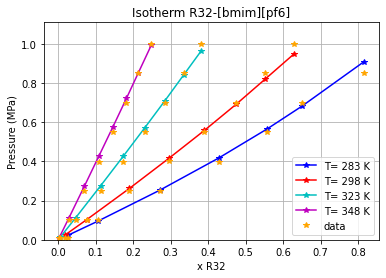

In [14]:
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

plt.plot(R32_x[0:7],P1[0:7],"b*-",label="T= 283 K")  
plt.plot(R32_x[7:15],P1[7:15],"r*-",label="T= 298 K") 
plt.plot(R32_x[15:23],P1[15:23],"c*-",label="T= 323 K") 
plt.plot(R32_x[23:31],P1[23:31],"m-*",label="T= 348 K")
plt.plot(data_full["x_R32"],data_full["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R32-[bmim][pf6]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,1.110000)
plt.legend()
plt.show()

### Print Eigvals, Eigvectors

An identifiability analysis can be performed with these as well as a FIM because the covariance matrix is the inverse of the FIM. That means that if there are any eigvals > 0, their eigvecs indicate directions of un-identifiability.

In [15]:
eigvals, eigvecs = np.linalg.eig(cov)

In [16]:
eigvals

array([9.77428520e-03, 2.91483141e-10, 6.81767330e-05])

In [17]:
eigvecs

array([[ 1.24036319e-02,  9.99853307e-01,  1.18116268e-02],
       [ 7.47537035e-01, -1.71175998e-02,  6.63999525e-01],
       [-6.64104308e-01, -5.93622799e-04,  7.47639696e-01]])

In [18]:
np.savetxt('Data/EigenAnalysis/PR_vals_3parameter_HFCILB0.csv',eigvals,delimiter=',')
np.savetxt('Data/EigenAnalysis/PR_vecs_3parameter_HFCILB0.csv',eigvecs,delimiter=',')

Conclusion: 

## AIC Value

See https://docs.google.com/document/d/1um0r2XK4ldjjy2colOqaZsEM3wIzGD6l_3B8gnpnI2I/edit# for equations

In [19]:
n = 3

In [20]:
SSR = obj_value

In [21]:
sigma_sq = SSR/n
sigma_sq

0.16649401310055822

In [22]:
L = -n/2*np.log(2*np.pi) - n/2*np.log(sigma_sq) - 1/(2*sigma_sq)*SSR
L

-1.5676217082708317

In [23]:
AIC = 2*n - 2*L
AIC

9.135243416541662

In [24]:
AIC_data = pd.DataFrame(data=[n,obj_value,AIC])
AIC_data = AIC_data.T
AIC_data.columns = ['n','Objective, Pa^2','AIC']
AIC_data.to_csv('Data/AIC/PR_AIC_3parameter_HFCILB0.csv')